In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def drop_useless_cols(df, drop_values = []):
    continuous_columns = ['amount_tsh', 'date_recorded', 'gps_height', 'population', 'construction_year']
    for cont in continuous_columns:
        if cont in drop_values:
            print(f'you cannot drop column: {cont}')
            return
        
    try:
        df_dropped = df.drop(drop_values, axis = 1)
        return df_dropped
    except:
        return df
    
def load_data(string1, string2):
    """
        pass in two strings containg csv info, this function will load the two dataframes and merge them along the column 'id'
    """
    df_1 = pd.read_csv(string1)
    df_2 = pd.read_csv(string2)
    #merging dataframes
    df = pd.merge(df_1, df_2, on = 'id', how = 'inner')
    return df

    
def fix_dates(df):
    """ will take the date of 01/01/2020 and subtract it from the 'date_recorded' column.
        This information will be stored in column called 'days_since_recording'
        This will also drop the 'date_recorded' column
    """
    basedate = datetime(2020, 1, 1)
    df['days_since_recording'] = df.loc[:,'date_recorded'].map(lambda x: (basedate - datetime.strptime(x, "%Y-%m-%d")).days)
    df.drop(['date_recorded'], axis = 1, inplace = True)
    return df

def clean_data(df, threshold = 100):
    # replaces NaN with a string 'not known'
    df = df.fillna('Not Known')
    
    uvdict = {}

    for column in df.select_dtypes(exclude=['int','float']):
        values_list = df[column].unique()
        uvdict[column] = len(values_list)

    target_list = list(filter(lambda x: uvdict[x] > threshold, uvdict.keys()))
                       
                       
    for col in target_list:
        valued_dict = dict(df[col].value_counts())
        safe_values = list(key for key, value in valued_dict.items() if value >= 50)
    #     replace_values = list(filter(lambda x: x not in safe_values, all_values))
        df.loc[:, col] = df.loc[:, col].map(lambda y: 'other' if y not in safe_values else y)
    
    
    return df

def bin_me(df):
    """
        creates bins for construction_year based on 5 year increments
        inaddition, values stored as year 0 will be transformed to not_available
    """
    try:
        basedate = datetime(2020, 1, 1)
        a = list(range(1955,2016,5))
        cut_bins = [-1]
        cut_bins.extend(a)
        cut_labels = ['not available', '56-60','61-65','66-70','71-75','76-80','81-85','86-90','91-95','96-00','01-05','06-10','11-15']
        df.loc[:, 'construction_year_bin'] = pd.cut(df['construction_year'], bins = cut_bins, labels = cut_labels)
        df.drop(['construction_year'], axis = 1, inplace = True)
        return df
    except:
        if 'construction_year_bin' in df.columns:
            print('action already performed')
        else:
            print('you messed up')

def onehotmess(df):
    df_objects = df.select_dtypes(exclude=['int','float']).drop(['status_group'], axis = 1)
    df_nums = df.select_dtypes(include=['int','float'])

    df_onehot = pd.get_dummies(df_objects)

    df_final = pd.concat([df_nums, df_onehot], axis = 1)
    
    return df_final, df.status_group

def normalize_func(df_values, df_target):
    X_train, X_test, y_train, y_test = train_test_split(df_values, df_target, test_size = .05, random_state = 42)
    scaler = MinMaxScaler()
    
    X_train_ = scaler.fit_transform(X_train)
    X_test_ = scaler.transform(X_test)
    
    return X_train_, X_test_, y_train, y_test


def do_everything(string1, string2, drop_values, thresh = 200):
    """this funciton is magical and does everything we could ever want and more"""
    loaded_data = load_data(string1, string2)
    df_dropped = drop_useless_cols(loaded_data, drop_values)
    fixed_date = fix_dates(df_dropped)
    cleaner_df = clean_data(fixed_date, thresh)
    df_binned = bin_me(cleaner_df)
    ohm_df, target_df = onehotmess(df_binned)
    X_train, X_test, y_train, y_test = normalize_func(ohm_df, target_df)
    
    return X_train, X_test, y_train, y_test, ohm_df, target_df

### Load initial Data
this will load the initial data, clean it, and then perfrom a train_test split on the dataframe to return X_train, X_test, y_train and y_test. All this is done in the 'do_evereything()' function

In [60]:
string_1 = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv'
string_2 = 'Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv'
drop_columns = ['id', 'funder', 'num_private', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region_code', 'lga',
                'ward','recorded_by', 'scheme_name', 'extraction_type_group', 'payment', 'quality_group', 
                'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']


X_train, X_test, y_train, y_test, df_values, df_target = do_everything(string_1, string_2, drop_columns)

### Perform Gradient Boosting Classifier

In [4]:
GBR = GradientBoostingClassifier(n_estimators = 200)


GBR.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [5]:
gbr_weight = GBR.score(X_test, y_test)


### Logistic Regression

In [6]:
LR = LogisticRegression(random_state = 0)

In [7]:
LR.fit(X_train, y_train)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
preds_test = LR.predict(X_test)

lr_weight = LR.score(X_test, y_test)

### Random Forest Classifier

In [9]:
RF = RandomForestClassifier(n_estimators = 200, random_state = 7)

RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [10]:
rf_weight = RF.score(X_test, y_test)

### KNN Classifier


In [11]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [12]:
knn_weight = knn.score(X_test, y_test)


### Voting Classifier
for the voting classifier we will use both hard and soft voting to see which one yields a higher accuracy

In [13]:
RF1 = RandomForestClassifier(n_estimators = 200)
LR1 = LogisticRegression()
GBR1 = GradientBoostingClassifier(n_estimators = 300)
KNN1 = KNeighborsClassifier()

In [14]:
eclf_hard = VotingClassifier(estimators = [('lr', LR1), ('rf', RF1), ('gbr', GBR1), ('knn', KNN1)], weights = [lr_weight, rf_weight, gbr_weight, knn_weight])

In [15]:
eclf_hard.fit(X_train, y_train)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [16]:
eclf_hard.score(X_test, y_test)

0.8107744107744108

In [17]:
eclf_soft = VotingClassifier(estimators = [('lr', LR1), ('rf', RF1), ('gbr', GBR1), ('knn', KNN1)], weights = [lr_weight, rf_weight, gbr_weight, knn_weight], voting = 'soft')

In [18]:
eclf_soft.fit(X_train, y_train)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [19]:
eclf_soft.score(X_test, y_test)

0.8121212121212121

In [20]:
preds = eclf_soft.predict(X_test)

In [25]:
y_test

2980              non functional
5246                  functional
22659                 functional
39888             non functional
13361                 functional
                  ...           
15075                 functional
48969                 functional
37665                 functional
22035             non functional
4800     functional needs repair
Name: status_group, Length: 2970, dtype: object

In [30]:
cm = confusion_matrix(y_test, preds)
cm

array([[1500,   17,  123],
       [ 118,   46,   28],
       [ 263,    9,  866]])

In [61]:
df_target = pd.get_dummies(df_target)

In [62]:
df = pd.concat([df_target, df_values], axis = 1)
df

,functional,functional needs repair,non functional,amount_tsh,gps_height,district_code,population,days_since_recording,installer_0,installer_ACRA,...,construction_year_bin_66-70,construction_year_bin_71-75,construction_year_bin_76-80,construction_year_bin_81-85,construction_year_bin_86-90,construction_year_bin_91-95,construction_year_bin_96-00,construction_year_bin_01-05,construction_year_bin_06-10,construction_year_bin_11-15
0,1,0,0,6000.0,1390,5,109,3215,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0.0,1399,2,280,2492,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,25.0,686,4,250,2501,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0.0,263,63,58,2529,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0.0,0,1,0,3094,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,1,0,0,10.0,1210,5,125,2434,0,0,...,0,0,0,0,0,0,1,0,0,0
59396,1,0,0,4700.0,1212,4,56,3161,0,0,...,0,0,0,0,0,0,1,0,0,0
59397,1,0,0,0.0,0,7,0,3187,0,0,...,0,0,0,0,0,0,0,0,0,0
59398,1,0,0,0.0,0,4,0,3221,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df_corr = df.corr()
df_corr.sort_values(by = ['functional needs repair'], inplace = True)

In [71]:
df_corr.head()

,functional,functional needs repair,non functional,amount_tsh,gps_height,district_code,population,days_since_recording,installer_0,installer_ACRA,...,construction_year_bin_66-70,construction_year_bin_71-75,construction_year_bin_76-80,construction_year_bin_81-85,construction_year_bin_86-90,construction_year_bin_91-95,construction_year_bin_96-00,construction_year_bin_01-05,construction_year_bin_06-10,construction_year_bin_11-15
functional,1.000000,-0.305207,-0.861212,0.052427,0.112990,-0.056028,0.017674,0.037747,0.006849,0.059927,...,-0.058738,-0.085880,-0.093276,-0.080547,-0.023672,-0.006646,0.024496,0.048363,0.149407,0.067894
non functional,-0.861212,-0.221146,1.000000,-0.051170,-0.106942,0.070882,-0.016576,-0.017953,0.009274,-0.051126,...,0.062939,0.086885,0.089166,0.081895,0.023840,0.011561,-0.023405,-0.044443,-0.136663,-0.060448
quantity_dry,-0.356422,-0.088143,0.412057,-0.021527,-0.080755,0.072606,-0.046496,-0.006438,0.025744,-0.018681,...,0.056067,-0.002373,0.063657,0.036775,0.015849,0.021843,-0.046875,-0.041465,-0.096134,-0.042118
region_Iringa,0.150156,-0.059574,-0.121980,0.092738,0.464455,-0.066920,-0.056795,0.344435,-0.036012,0.219219,...,-0.030118,-0.010002,0.074984,0.032831,0.041216,0.032070,0.027053,0.029754,0.122047,-0.042315
extraction_type_class_other,-0.267913,-0.054541,0.303480,-0.027298,-0.101542,0.048443,0.022151,-0.044882,-0.010544,-0.023891,...,-0.020583,-0.017330,0.023200,0.079333,0.036635,0.009472,-0.002693,-0.044751,-0.083498,-0.020811


In [74]:
df_corr.drop('functional', inplace = True)
df_corr.drop('non functional', inplace = True)
df_corr.drop('functional needs repair', inplace = True)

### creating plots

In [97]:
df_func_10_pos = df_corr.sort_values(by=['functional'], ascending = False)[['functional']].head(10)
df_func_10_pos

,functional
quantity_enough,0.246746
waterpoint_type_communal standpipe,0.151270
region_Iringa,0.150156
construction_year_bin_06-10,0.149407
payment_type_per bucket,0.114168
gps_height,0.112990
water_quality_soft,0.111673
extraction_type_class_handpump,0.108596
payment_type_annually,0.107358
extraction_type_class_gravity,0.102173


In [123]:
df_func_10_neg = df_corr.sort_values(by=['functional'], ascending = False)[['functional']].tail(11)
df_func_10_neg.drop('extraction_type_class_other', inplace = True)
df_func_10_neg

,functional
installer_Government,-0.089327
construction_year_bin_76-80,-0.093276
basin_Ruvuma / Southern Coast,-0.098422
management_vwc,-0.114188
waterpoint_type_communal standpipe multiple,-0.120148
water_quality_unknown,-0.145865
payment_type_never pay,-0.163102
extraction_type_other,-0.267913
waterpoint_type_other,-0.286499
quantity_dry,-0.356422


In [124]:
df_func_10 = pd.concat([df_func_10_pos, df_func_10_neg])
df_func_10

,functional
quantity_enough,0.246746
waterpoint_type_communal standpipe,0.151270
region_Iringa,0.150156
construction_year_bin_06-10,0.149407
payment_type_per bucket,0.114168
gps_height,0.112990
water_quality_soft,0.111673
extraction_type_class_handpump,0.108596
payment_type_annually,0.107358
extraction_type_class_gravity,0.102173


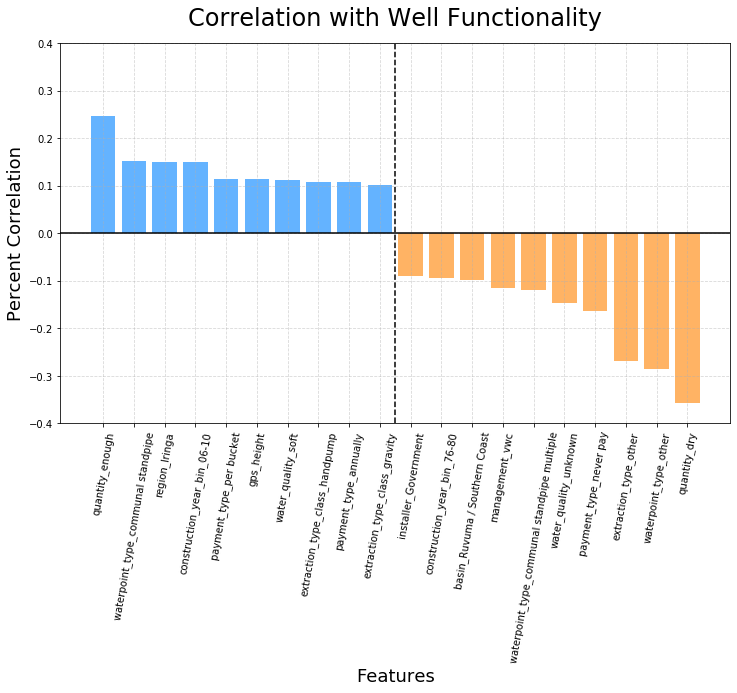

<Figure size 432x288 with 0 Axes>

In [226]:
labels = list(df_func_10.index)
x_pos = np.arange(len(labels))
values = list(df_func_10.functional)
color_b, color_r = ['#64b3ff']*(len(labels)//2), ['#ffb364']*(len(labels)//2)
color_b.extend(color_r)

fig_size = (12,7)

plt.figure(figsize = fig_size)
plt.bar(x_pos, values, align='center', color = color_b, alpha = 1)
plt.grid(zorder=0, alpha= .5, linestyle = '--')
plt.axvline(x=9.5, color = 'black', linestyle = '--')
plt.axhline(y=0, color = 'black')
plt.xticks(x_pos, labels, rotation=80, )
plt.xlabel('Features', fontsize = (fig_size[0])*3//2)
plt.ylabel('Percent Correlation', fontsize = (fig_size[0])*3//2)
plt.ylim(-.4, .4)
plt.title('Correlation with Well Functionality', fontsize=(fig_size[0])*2, y = 1.03)

plt.show()

plt.savefig('figures/corr_well_func.png')


In [150]:
df_non_func_10_pos = df_corr.sort_values(by=['non functional'], ascending = False)[['non functional']].head(11)
df_non_func_10_pos.drop('extraction_type_class_other', inplace = True)
df_non_func_10_neg = df_corr.sort_values(by=['non functional'], ascending = False)[['non functional']].tail(11)
df_non_func_10_neg.drop('extraction_type_class_gravity', inplace = True)
df_non_func_10_neg

,non functional
source_spring,-0.106184
gps_height,-0.106942
payment_type_annually,-0.107394
region_Iringa,-0.121980
payment_type_monthly,-0.129595
water_quality_soft,-0.135108
construction_year_bin_06-10,-0.136663
extraction_type_gravity,-0.157132
waterpoint_type_communal standpipe,-0.167879
quantity_enough,-0.251868


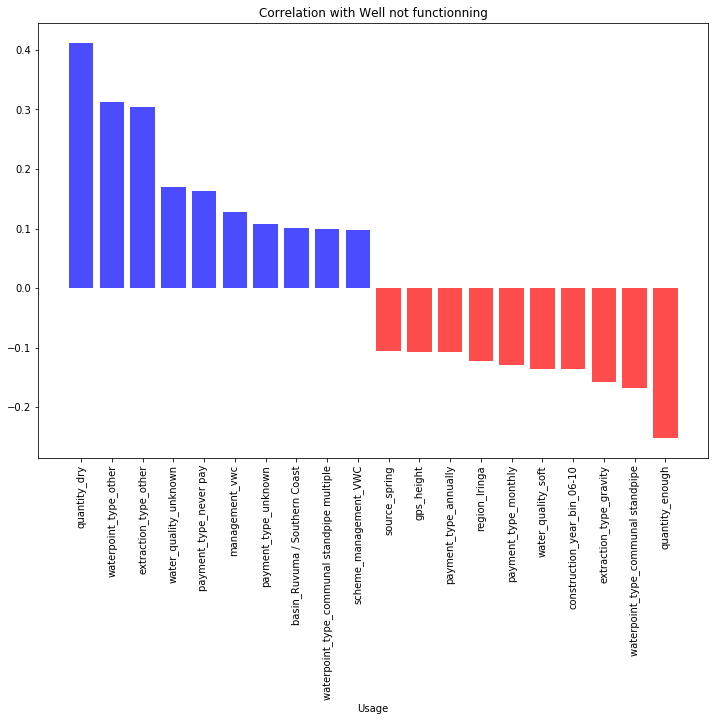

In [162]:
df_non_func = pd.concat([df_non_func_10_pos, df_non_func_10_neg])

labels = list(df_non_func.index)
x_pos = np.arange(len(labels))
values = list(df_non_func['non functional'])
color_b, color_r = ['blue']*(len(labels)//2), ['red']*(len(labels)//2)
color_b.extend(color_r)



plt.figure(figsize = (12,8))
plt.bar(x_pos, values, align='center', color = color_b, alpha = .7)
plt.xticks(x_pos, labels, rotation=90)
plt.xlabel('Usage')
plt.title('Correlation with Well not functionning')

plt.show()

In [166]:
func_repair_10_pos = df_corr.sort_values(by=['functional needs repair'], ascending = False)[['functional needs repair']].head(11)
func_repair_10_pos.drop('extraction_type_class_gravity', inplace = True)
func_repair_10_neg = df_corr.sort_values(by=['functional needs repair'], ascending = False)[['functional needs repair']].tail(11)
func_repair_10_neg.drop('extraction_type_class_other', inplace = True)
func_repair_10 = pd.concat([func_repair_10_pos,func_repair_10_neg])
func_repair_10

,functional needs repair
region_Kigoma,0.121557
extraction_type_gravity,0.098361
source_river,0.091991
scheme_management_WUG,0.067341
region_Shinyanga,0.063849
scheme_management_Water authority,0.063303
payment_type_monthly,0.060561
basin_Lake Tanganyika,0.057295
quantity_insufficient,0.052165
installer_DWE,0.050907


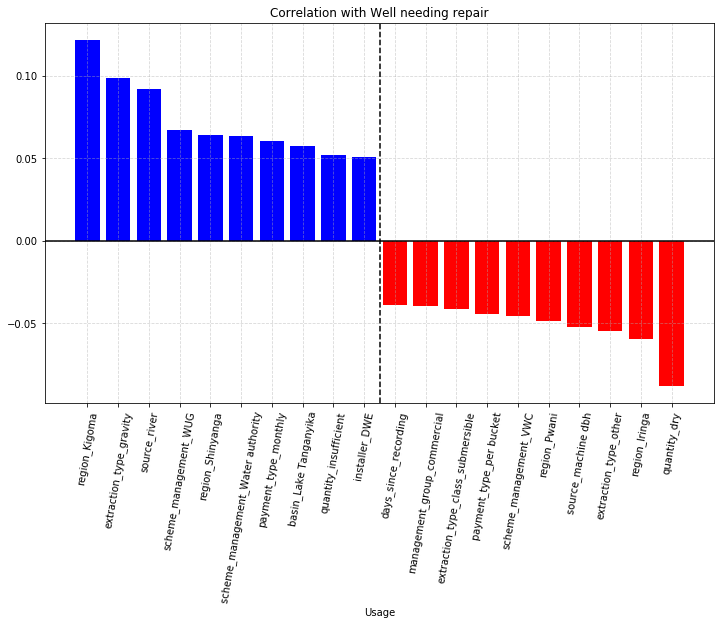

In [187]:
labels = list(func_repair_10.index)
x_pos = np.arange(len(labels))
values = list(func_repair_10['functional needs repair'])
color_b, color_r = ['blue']*(len(labels)//2), ['red']*(len(labels)//2)
color_b.extend(color_r)



plt.figure(figsize = (12,7))
plt.bar(x_pos, values, align='center', color = color_b, alpha = 1)
plt.grid(zorder=0, alpha= .5, linestyle = '--')
plt.axvline(x=9.5, color = 'black', linestyle = '--')
plt.axhline(y=0, color = 'black')
plt.xticks(x_pos, labels, rotation=80)
plt.xlabel('Usage')
plt.title('Correlation with Well needing repair')

plt.show()